# Analysing elements affecting employee attrition

# 1. Motivation, data, and research questions

Employee attrition has always been one of the most costly and difficult challenges to companies. Not only does it negatively impacts performance, (Tonz and Huckman, 2008) it also raises recruitment and training costs. In the UK, attrition costs businesses at least £4.13bn every year to train new employees to work at optimum productivity (Oxford Economics, 2017).

There has been numerous research on factors affecting attrition. However, the findings were not consistent due to the diversity of methods applied (Ongori, 2007). On the other hand, quantitative research was limited and dated back more than 10 years, and mostly implemented linear regression as analytical method with less than 300 observations (Micheals and Spector, 1982; Cotton et al., 1986; Hom and Kinicki, 2001; Morrell et al.,  2004; Ahituv and Lerman, 2005; Ekkehart, 2006; Cohen and Golan, 2007). In addition, recent analysis were not made available to the wide public. This situation where limited research is conducted on this topic can be explained by the increasing confidentiality of human resources data (Armstrong et al., 2014). 

In 2017, IBM has released a dataset on employee attrition with all personal identifiers removed for confidentiality purpose (Watson Analytics Forum, 2017). It contains information on the demographics, carrer progression, job specification of 1,470 employees from sales, research and human resources departments in the pharmaceutical industry. The population aged from 18 to 60 and took charge of all job levels, from executive to manager. As a result, this dataset may give interesting insight to employee attrition, especially in research-involved companies. This is also an opportunity to revisit empirical findings and to reconsider their applicability in the current context.

The aim of this analysis is to revisit previous research findings and identify then interpret the most significant factors that help explain employee attrition. With an interest in investigating how the explanation varies across age groups, this analysis seek to answer to the following questions:

- Are previous research findings help explain attrition in this case?
- What other factors best explain employee attrition?
- Are the explanations difference across age groups?

# 2. Tasks and approach 

**2.1. Characterise attrition variation by age**

To gain an overview of the distribution of employee attrition by age, a kernel density estimation plot was utilised (Figure 1 - left) with those who left represented in red and those who stayed represented in blue. To take into account of the population size of each age group, the attrition rate was visualised with scatter plot in which the size of each dot corresponds to the number of employee of that age (Figure 1 - right). Subsequently, age groups with similar trend in attrition rate were consolidated to larger groups. The attrition rate was again visualised to verify if the overall trend was captured (Figure 2). 

The aim of this grouping was also to provide input for the modelling stage where a local model is fitted to each group.

**2.2. Characterise age groups with selected features**

Available features that had been agreed as correlated to employee attrition by the majority of research were selected to describe the 3 age groups, which were: Performance (-), job and workplace satisfaction (-), age (-), job level (-), marital status (Married negative), education (+), income (-), promotion (-). Categorical features were then binary encoded, then the average value of each feature were visualised with a radar plot. 

This method highlighted the most significant differences between the groups, facilitating high level explanation of how attrition varies by age. This averaging method in general is not robust against outliers, but provides a representative employee profile. In addition, this method works with binary variables while median as its popular robust alternative cannot.

**2.3. Identify the association between features of each age group and attrition**

For each age group, radar plot was again selected to characterise leaving and staying employees. This technique allows the investigation of how each employee characteristic related to attrition in general and in each age group. In addition, analysing by age groups instead of the whole population ensures patterns in the smaller groups are not overwhelmed by larger ones.

**2.4. Assess findings and identify unconsidered features with logistic regression**

_**a. Model selection**_<br>
To assess how each feature contributed to attrition in each age group, logistic regression was selected. This method is particularly suitable for binary prediction tasks, facilitates interpretability but still produces decent prediction result comparing to other machine learning algorithms (Pailet et al., 2009). In addition, comparing to linear regression, it does not rely on assumptions such as normally distributed data, homogenity of variance, but would function best with in cases where data are linearly separable (Kotsiantis et al., 2007).

_**b. Data preparation**_<br>
Logistic regression's multicollinearity assumption was addressed with feature selection step. Features correlation were visualised with heatmap in which highly correlated features were identified. To minimise manual feature selection, only features containing information that can be derived from other features and are highly correlated with other features in the dataset; or containing no meaning were removed. Automatic feature selection was then performed with LASSO as the regularisation technique, allowing less important features to be excluded from the model.

Categorical features were binary encoded. The dataset was then normalised to zero mean and unit variance to facilitates convergence of gradient descent - which was used as the optimisation method (Ioffe and Szegedy, 2015). To address class imbalance (237 left/1470 records), the rare class was oversampled using SMOTE. This method helps improves classifier performance particularly in ROC space (Chawla et al., 2002).

_**c. Model evaluation and result interpretation**_<br>
The model performance was evaluated with ROC curve and confusion matrix. The output coefficients were represented in heatmap to facilitate comparision feature-wise and group-wise. Interpretation of the coefficient is then compared with the findings in previous section and that of empirical studies.

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [133]:
# Import the libraries
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import math
from scipy.interpolate import spline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
import itertools
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from sklearn.model_selection import train_test_split
from math import pi
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

# Import the data
data = pd.read_csv('Data.csv')

# Configuration
% matplotlib inline
pd.set_option("display.max_columns",99)
plt.style.use('ggplot')

i = 1 # Figure number

pd.options.display.float_format = '{:,.2f}'.format

**Age**

The chart below illustrates the relationship between attrition rate and age.

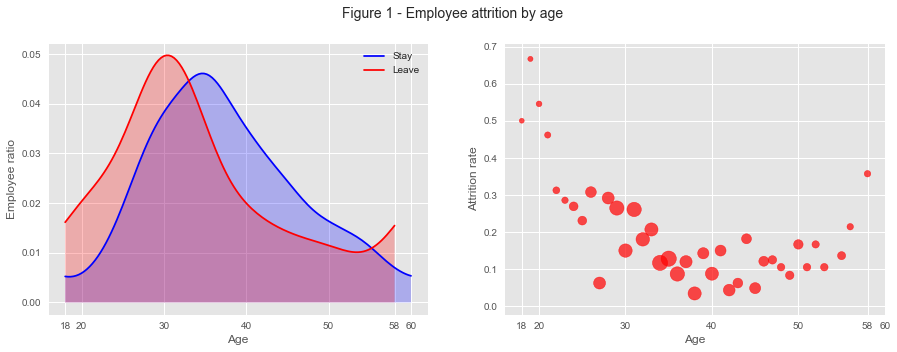

In [3]:
###### Data preparation

# Dividing employee by attrition status
att_y = data.loc[(data.Attrition == 'Yes')]
att_n = data.loc[(data.Attrition == 'No')]

# Summarising attrition by age
tp = pd.pivot_table(data,index='Age', columns='Attrition', aggfunc='size')
tp2 = tp.div(tp.sum(1), axis=0)

###### Plotting

# Plotting Attrition distribution by age
figure = plt.figure(figsize = (15,5))
plt.suptitle('Figure {} - Employee attrition by age'.format(i), fontsize = 14)
i += 1 

# Density estimation 
figure.add_subplot(121)
ax2 = sns.kdeplot(att_n.Age, shade=True, color="b", cut = 0)
ax1 = sns.kdeplot(att_y.Age, shade=True, color="r", cut = 0)
plt.xticks([18, 20, 30, 40, 50, max(att_y.Age), 60])
plt.xlabel('Age')
plt.ylabel('Employee ratio')
plt.legend(('Stay', 'Leave'))

# Scatter plot
figure.add_subplot(122)
plt.scatter(tp2.index, tp2.Yes, s = tp.sum(1)*3, alpha = 0.7, c = 'r')
plt.xlabel('Age')
plt.ylabel('Attrition rate')
plt.xticks([18, 20, 30, 40, 50, max(att_y.Age), 60])
plt.show()

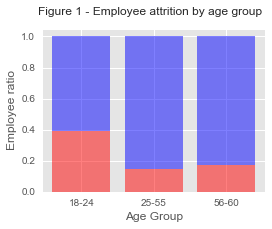

In [2]:
# Encoding age group
AgeGrp = data.Age.copy()

for j in range(len(data)):
    if data.loc[j,'Age'] < 25:
        AgeGrp[j] = 1
    elif data.loc[j,'Age'] < 56:
        AgeGrp[j] = 2
    else:
        AgeGrp[j] = 3

# Summarising by age group
tp = pd.pivot_table(data,index=AgeGrp, columns='Attrition', aggfunc='size')
tp = tp.div(tp.sum(1), axis=0)

# Plotting
figure = plt.figure(figsize = (4,3))
plt.suptitle('Figure {} - Employee attrition by age group'.format(i))
i += 1
ax1 = plt.bar(np.arange(3), tp.values[:,0], alpha = 0.5, bottom = tp.values[:,1], color = 'b')
ax2 = plt.bar(np.arange(3), tp.values[:,1], alpha = 0.5, color = 'r')
plt.xticks((0,1,2),('18-24','25-55','56-60'), rotation='horizontal')
plt.xlabel('Age Group')
plt.ylabel('Employee ratio')
plt.show()

Some features were removed from the dataset for the following reasons:
- _**"EmployeeCount", "Over18",**_ and **_"StandardHours"**:_ Contains only "1", "Y" and "80" respectively;
- **_"EmployeeNumber"_**: Has no meaning as in correlation heatmap;
- **_"JobRole"_**: Can be derived from "Job Level" and "Department";
- **_"MonthlyIncome"_**: Highly correlated with "Job Level";
- **_"PerformanceRating"_**: Highly correlated with "PercentSalaryHike", value ranged from 3 to 4 only.

In [134]:
colorMappingValuesCrime = np.asarray(data.Age, 'f')

In [135]:
numericColumns = data._get_numeric_data()

# Centralise data
numericColumns -= numericColumns.mean()

distMatrix = euclidean_distances(numericColumns, numericColumns)

mds = manifold.MDS(n_components = 2, max_iter=3000, n_init=1, dissimilarity="precomputed")
Y = mds.fit_transform(distMatrix)



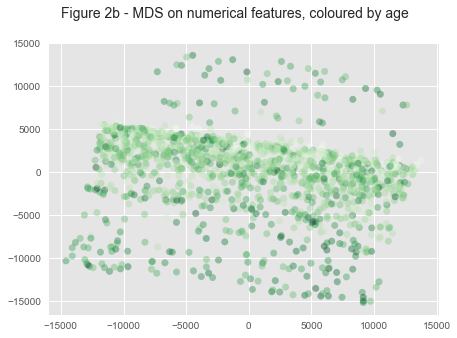

In [139]:
colordict = {1: (0.1, 0.2, 0.5), 2: (1.0, 0.55, 0.0, 1.0), 3: (0.11, 0.65, 0.72, 0.1)}
colormapping = [colordict[i] for i in AgeGrp]

figure = plt.figure(figsize = (7,5))
plt.suptitle('Figure {} - MDS on numerical features, coloured by age '.format('2b'), fontsize = 14)
i += 1

plt.scatter(Y[:, 0], Y[:, 1], c= colorMappingValuesCrime, cmap = plt.cm.Greens, alpha = 0.4, linewidth='0')

plt.show()

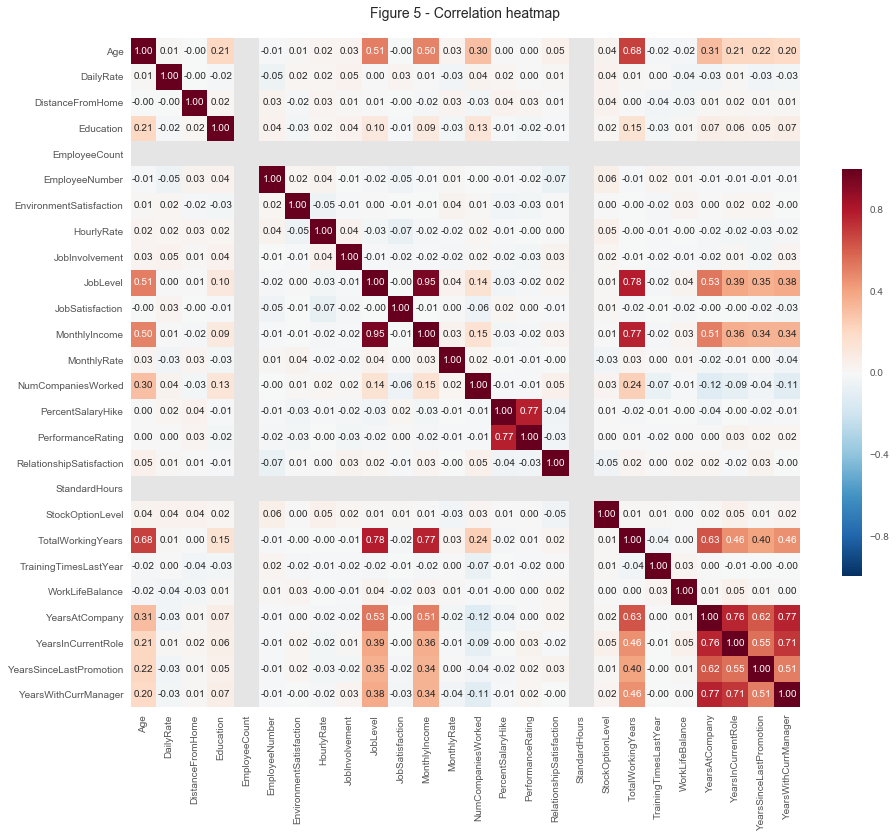

In [196]:
figure7 = plt.figure(figsize = (15,15))
att_corr = data.corr()
sns.heatmap(att_corr, xticklabels=att_corr.columns.values, yticklabels=att_corr.columns.values,annot=True, square = True, fmt = '.2f', cbar = True, cbar_kws={"shrink": .5}, vmin = -1, vmax = 1)
plt.title('Figure {} - Correlation heatmap'.format(5), fontsize = 14)
i += 1
plt.show()

In [3]:
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber', 'JobRole', 'MonthlyIncome', 'PerformanceRating'], axis = 1)

# Data preparation

In [4]:
# Encode categorical variables with one hot encoding
data_enc = pd.get_dummies(data, columns = ['Gender','MaritalStatus','OverTime','Department','EducationField','Attrition'], drop_first = True)

# Encode BusinessTravel frequency
data_enc['TravelFreq'] = [0 if j == 'Non_Travel' else 1 if j == 'Travel_Rarely' else 2 for j in data.BusinessTravel]
data_enc = data_enc.drop('BusinessTravel', axis = 1)

# Normalising data to 0 and 1
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data_enc)
data_norm = pd.DataFrame(data_norm, columns = data_enc.columns)
# data_norm.head()

In [8]:
########## Data preparation
# Choosing factors to plot in radar plot
data_radar = data_norm.loc[:,['Age', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
                              'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyRate', 
                              'PercentSalaryHike', 'MaritalStatus_Married', 'MaritalStatus_Single', 
                              'OverTime_Yes','TravelFreq' ]]

In [9]:
def radar(Group1, alpha1, Group2, alpha2, Group3, alpha3, row,col, subplotindex):
    # Preparing data
    radar_Group1 = Group1.mean()
    radar_Group2 = Group2.mean()
    radar_Group3 = Group3.mean()
    
    a = pd.DataFrame(radar_Group1.reshape(1,len(radar_Group1)), columns = radar_Group1.index)
    b = pd.DataFrame(radar_Group2.reshape(1,len(radar_Group2)), columns = radar_Group2.index)
    c = pd.DataFrame(radar_Group3.reshape(1,len(radar_Group3)), columns = radar_Group3.index)
    
    z = pd.concat([a,b,c]).reset_index(drop = True)
    
    categories=list(z)[1:]
    N = len(categories)
    
    values1= z.loc[0].drop('Age').values.flatten().tolist()
    values1 += values1[:1]
    
    values2= z.loc[1].drop('Age').values.flatten().tolist()
    values2 += values2[:1]
    
    values3= z.loc[2].drop('Age').values.flatten().tolist()
    values3 += values3[:1]
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ###### Plotting
    ax = figure.add_subplot(row, col, subplotindex, polar=True)
    plt.xticks(angles[:-1], ['             Education', 
                         '                                     Environment Satisfaction', 
                         '     Hourly Rate', 'Job Involvement', 'Job Level', 'Job Satisfaction                  ', 
                         'Monthly Rate                 ', '% Salary Hike                 ', 'Married', 'Single', 
                         '      Overtime', '                           Travel Frequency'], color='black', size=14)
    ax.set_rlabel_position(0)
    ax.plot(angles, values1, linewidth=2, c = 'b', alpha = alpha1)
    #ax.fill(angles, values1, 'b', alpha=0.2)
    
    ax.plot(angles, values2, linewidth=2, c = 'r', alpha = alpha2)
    #ax.fill(angles, values2, 'r', alpha=0.2)
    
    ax.plot(angles, values3, linewidth=2, c = 'g', alpha = alpha3)
    #ax.fill(angles, values3, 'g', alpha=0.2)
    
    plt.yticks(size = 0.00001)
    
    plt.legend(['18 - 24','25 - 55','56 - 60'], loc = (1,0.9))

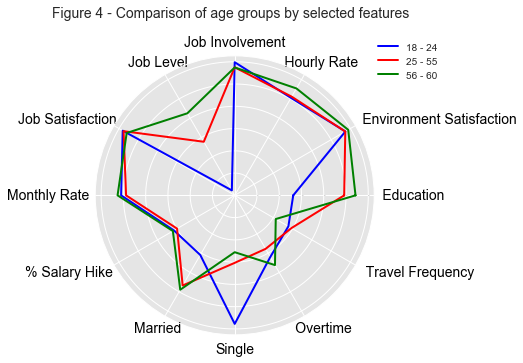

In [10]:
figure = plt.figure(figsize = (5,5.5))
plt.suptitle('Figure {} - Comparison of age groups by selected features'.format(i), fontsize = 14)
i += 1

Group1 = data_radar.loc[(AgeGrp == 1)]
Group2 = data_radar.loc[(AgeGrp == 2)]
Group3 = data_radar.loc[(AgeGrp == 3)]
    
radar(Group1, 1, Group2, 1, Group3, 1, 1,1,1)
plt.legend(['18 - 24','25 - 55','56 - 60'], loc = (1,0.9))

plt.show()

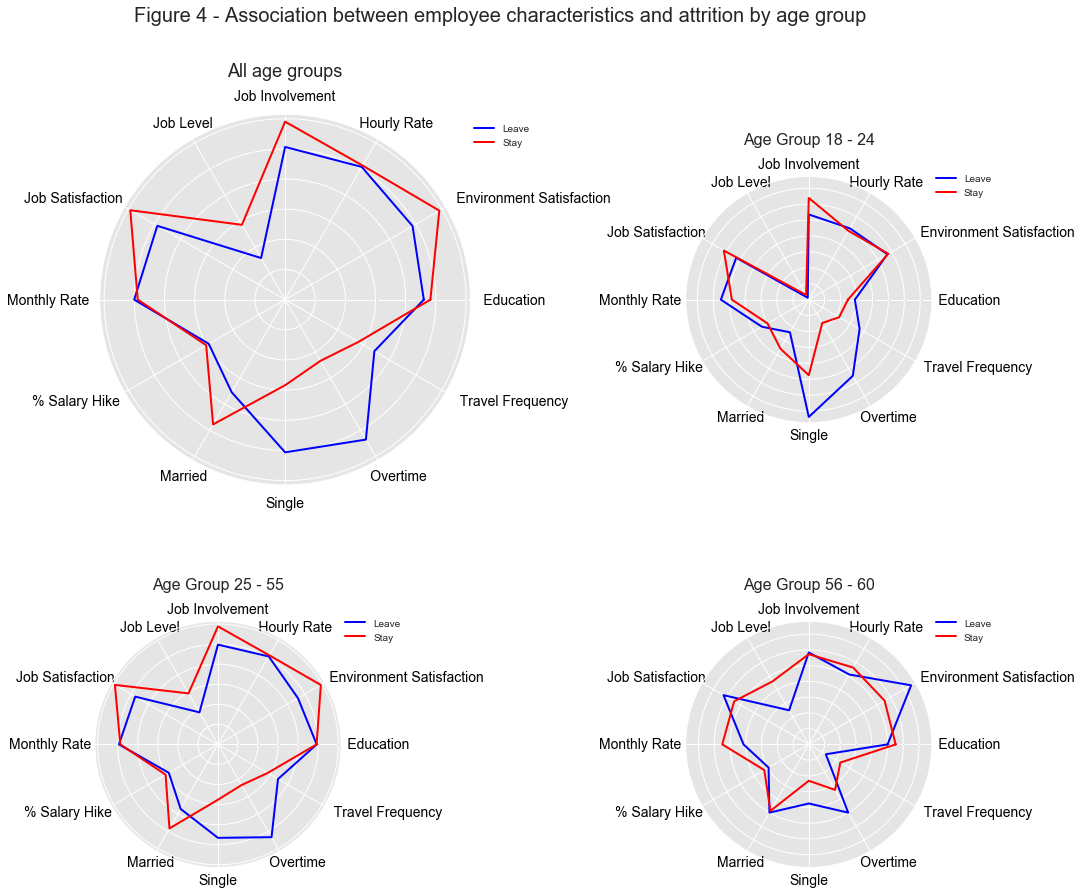

In [11]:
figure = plt.figure(figsize = (15,15))
plt.suptitle('Figure {} - Association between employee characteristics and attrition by age group'.format(4), fontsize = 20)
i += 1

Group1 = data_radar.loc[(data.Attrition == 'Yes')]
Group2 = data_radar.loc[(data.Attrition == 'No')]
Group3 = data_radar.loc[(data.Attrition == 'No')]
    
radar(Group1, 1, Group2, 1, Group3, 0, 2,2,1)
plt.legend(['Leave','Stay'], loc = (1,0.9))
plt.title('All age groups', fontsize = 18)

for j, k, l in zip(range(1,4),['18 - 24','25 - 55','56 - 60'],[3,4,6]):
    Group1 = data_radar.loc[(AgeGrp == j) & (data.Attrition == 'Yes')]
    Group2 = data_radar.loc[(AgeGrp == j) & (data.Attrition == 'No')]
    
    radar(Group1, 1, Group2, 1, Group3, 0, 2,3,l)
    plt.legend(['Leave','Stay'], loc = (1,0.9))
    plt.title('Age Group {}'.format(k), fontsize = 16)

plt.show()

# Model fitting

## Data preprocessing

In [71]:
# Specifying predictors and output for global model
X = data_norm.drop('Attrition_Yes',axis =1)
Y = data_norm.Attrition_Yes

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Specifying predictors and output for local model
listX = []
listY = []
for j in range(1,4):
    globals()["X" + str(j)] = X[AgeGrp == j]
    globals()["Y" + str(j)] = Y[AgeGrp == j]

listX = [X1, X2, X3]
listY = [Y1, Y2, Y3]
    
for j in range(1,4):
    globals()["Xtrain" + str(j)],_,_,_ = train_test_split(listX[j-1], listY[j-1], test_size = 0.2, random_state = 0)
    _,globals()["Xtest" + str(j)],_,_  = train_test_split(listX[j-1], listY[j-1], test_size = 0.2, random_state = 0)
    _,_,globals()["Ytrain" + str(j)],_ = train_test_split(listX[j-1], listY[j-1], test_size = 0.2, random_state = 0)
    _,_,_,globals()["Ytest" + str(j)]  = train_test_split(listX[j-1], listY[j-1], test_size = 0.2, random_state = 0)

listXtrain = [Xtrain1, Xtrain2, Xtrain3]
listXtest = [Xtest1, Xtest2, Xtest3]
listYtrain = [Ytrain1, Ytrain2, Ytrain3]
listYtest = [Ytest1, Ytest2, Ytest3]

## Oversampling

In [6]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=0)
os_Xtrain,os_Ytrain = oversampler.fit_sample(Xtrain,Ytrain)

## Modelling

In [47]:
Xtrain1.reset_index(drop=True).head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,TravelFreq
0,0.10,0.81,0.00,0.25,1.00,0.04,0.33,0.25,1.00,0.68,0.67,0.79,0.00,0.67,0.10,0.33,0.00,0.05,0.11,0.13,0.12,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,0.14,0.63,0.57,0.25,1.00,0.96,0.67,0.00,0.33,0.05,0.11,0.14,0.00,0.33,0.03,0.50,0.00,0.03,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,0.14,0.51,0.00,0.50,0.33,0.44,0.67,0.00,1.00,0.04,0.22,0.36,0.00,0.33,0.15,0.33,0.33,0.05,0.00,0.13,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.12,0.04,0.11,0.00,0.67,0.30,0.67,0.00,0.33,0.43,0.11,0.14,0.67,0.00,0.08,0.50,0.00,0.08,0.11,0.07,0.12,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,0.05,0.28,0.04,0.50,0.67,0.27,0.33,0.00,0.67,0.80,0.11,0.14,1.00,0.00,0.05,0.50,0.33,0.05,0.11,0.00,0.12,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00


In [45]:
Ytrain1 = pd.DataFrame(Ytrain1).reset_index(drop = True)

In [129]:
# Training global models with different specs

Xtrain3 = scaler.fit_transform(Xtrain3)
Xtrain3 = pd.DataFrame(Xtrain3, columns = Xtrain2.columns)

cparams = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lr_results = pd.DataFrame(columns = cparams)

for v in cparams:
    lr = LogisticRegression(fit_intercept = False, C = v, class_weight = 'balanced', penalty = 'l2')
    lr.fit(Xtrain3, Ytrain3)
    Ypred_score = lr.fit(Xtrain3, Ytrain3).decision_function(Xtest3)
    fpr, tpr, thresholds = precision_recall_curve(Ytest3, Ypred_score)
    lr_results.loc[0,v] = average_precision_score(Ytest3, Ypred_score)

# Selecting best global model
lr = LogisticRegression(fit_intercept = False, C = 10, class_weight = 'balanced', penalty = 'l2')
lr.fit(Xtrain3, Ytrain3)

# Predicting
Ypred = lr.predict(Xtest3)

# Recording LR output
lr_output = pd.DataFrame(lr.coef_, columns = X.columns)

In [130]:
lr_results

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
0,0.20,0.20,0.18,0.18,0.16,0.16,0.16,0.16,0.16


In [124]:
lr_output.to_clipboard()

In [127]:
# Training global models with different specs

cparams = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lr_results = pd.DataFrame(columns = cparams)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

for v in cparams:
    lr = LogisticRegression(fit_intercept = False, C = v, class_weight = 'balanced', penalty = 'l2')
    lr.fit(Xtrain1, Ytrain1)
    Ypred_score = lr.fit(Xtrain1, Ytrain1).decision_function(Xtest1)
    fpr, tpr, thresholds = precision_recall_curve(Ytest1, Ypred_score)
    lr_results.loc[0,v] =  average_precision_score(Ytest1, Ypred_score)

# Selecting best global model
lr = LogisticRegression(fit_intercept = False, C = 1, class_weight = 'balanced', penalty = 'l2')
lr.fit(Xtrain1, Ytrain1)

# Predicting
Ypred = lr.predict(Xtest1)

# Recording LR output
lr_output = pd.DataFrame(lr.coef_, columns = X.columns)

In [90]:
Xtrain1 = scaler.fit_transform(Xtrain1)
Xtrain1 = pd.DataFrame(Xtrain1, columns = Xtrain2.columns)

In [128]:
lr_results

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
0,0.68,0.68,0.69,0.70,0.73,0.69,0.73,0.77,0.76


In [106]:
lr_output.to_clipboard()

In [96]:
# Training global models with different specs

cparams = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lr_results = pd.DataFrame(columns = cparams)

for v in cparams:
    lr = LogisticRegression(fit_intercept = False, C = v, penalty = 'l2')
    lr.fit(os_Xtrain, os_Ytrain)
    Ypred_score = lr.fit(os_Xtrain, os_Ytrain).decision_function(Xtest)
    fpr, tpr, thresholds = roc_curve(Ytest, Ypred_score)
    lr_results.loc[0,v] = auc(fpr,tpr)

# Selecting best global model
lr = LogisticRegression(fit_intercept = False, class_weight = 'balanced', C = float(lr_results.idxmax(1)), penalty = 'l2')
lr.fit(os_Xtrain, os_Ytrain)

# Predicting
Ypred = lr.predict(Xtest)

# Recording LR output
lr_output = pd.DataFrame(lr.coef_, columns = X.columns)

In [97]:
float(lr_results.idxmax(1))

0.1

In [98]:
lr_results

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
0,0.82,0.82,0.84,0.84,0.83,0.83,0.83,0.83,0.83


In [99]:
lr_output

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,TravelFreq
0,-0.95,-0.37,0.78,0.39,-0.66,0.19,-0.62,-1.16,-0.70,0.51,0.74,-0.37,-0.19,-0.11,-0.56,-0.11,-0.37,0.20,-0.92,0.75,-0.71,0.38,0.61,1.10,1.36,0.02,0.34,-0.14,0.50,-0.13,-0.05,0.35,0.26


In [102]:
# Fitting local models
for j,k in zip(listXtrain, listYtrain):
    # Training local model with specs from best global model
    lr.fit(j, k)
    # Append LR output
    lr_output = lr_output.append(pd.DataFrame(lr.coef_, columns = X.columns))

lr_output.to_clipboard()

In [158]:
# Fitting local models

for j, k, l, m in zip(listXtrain, listYtrain, listXtest, listYtest):
    for v in cparams:
        lr = LogisticRegression(fit_intercept = False, C = v, penalty = 'l2')
        lr.fit(j, k)
        Ypred_score = lr.fit(j, k).decision_function(l)
        fpr, tpr, thresholds = roc_curve(m, Ypred_score)
        lr_results.loc[0,v] = auc(fpr,tpr)
        
    lr = LogisticRegression(fit_intercept = False, class_weight = 'balanced', C = float(lr_results.idxmax(1)) if float(lr_results.min(1)) >0.5 else float(lr_results.idxmin(1)), penalty = 'l2')
    lr.fit(j, k)
    
    # Recording LR output
    lr_output = lr_output.append(pd.DataFrame(lr.coef_, columns = X.columns))

In [160]:
lr_output

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,TravelFreq
0,-0.95,-0.37,0.78,0.39,-0.66,0.19,-0.62,-1.16,-0.70,0.51,0.74,-0.37,-0.19,-0.11,-0.56,-0.11,-0.37,0.20,-0.92,0.75,-0.71,0.38,0.61,1.10,1.36,0.02,0.34,-0.14,0.50,-0.13,-0.05,0.35,0.26
0,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
0,-0.31,0.26,1.55,0.62,-1.11,-0.24,-1.09,-1.81,-0.93,0.53,1.26,-0.30,-0.70,-0.44,-1.88,-0.46,-0.43,3.28,-2.16,1.39,-1.48,0.21,0.71,1.23,1.67,-0.46,0.35,0.45,0.99,0.79,0.76,1.66,0.36
0,-0.91,-4.13,0.57,1.17,1.50,-0.99,-0.26,-2.11,-0.44,-0.65,2.41,0.47,-0.13,0.31,-0.28,-1.16,-0.00,1.12,1.15,1.62,0.38,-1.19,0.23,1.79,0.42,0.88,-1.15,-1.34,-0.37,-0.31,0.00,1.31,-1.15


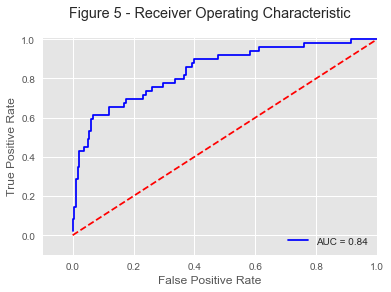

In [16]:
# Prepare to plot ROC
Ypred_score = lr.fit(os_Xtrain, os_Ytrain).decision_function(Xtest)
fpr, tpr, thresholds = roc_curve(Ytest, Ypred_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Figure 5 - Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

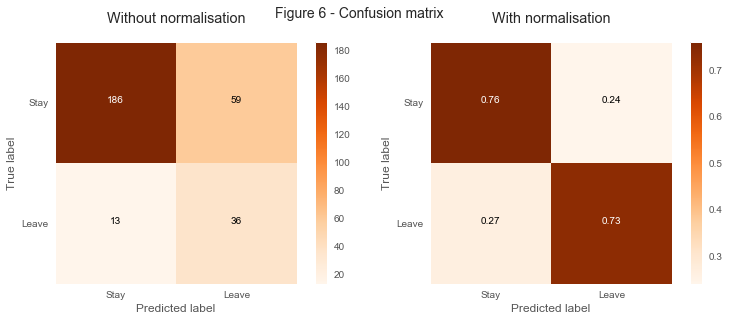

In [52]:
# Plotting confusion matrix, taken from scikit learn 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Ytest, Ypred)
np.set_printoptions(precision=2)

class_names = ['Stay','Leave']

# Plot non-normalized confusion matrix
figure9 = plt.figure(figsize = (11,4.5))
plt.suptitle('Figure 6 - Confusion matrix', fontsize = 14)

figure9.add_subplot(121).grid()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Without normalisation')

# Plot normalized confusion matrix
figure9.add_subplot(122).grid()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='With normalisation')

plt.show()

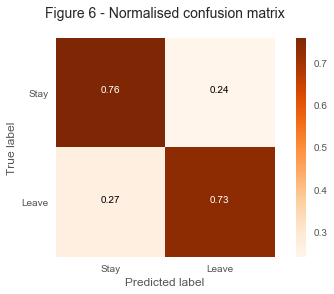

In [63]:
# Plot non-normalized confusion matrix
#figure9 = plt.figure(figsize = (6,4))
#figure9.add_subplot(111).grid()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
#plt.title('Figure 6 - Normalised confusion matrix', fontsize = 14)

#plt.show()

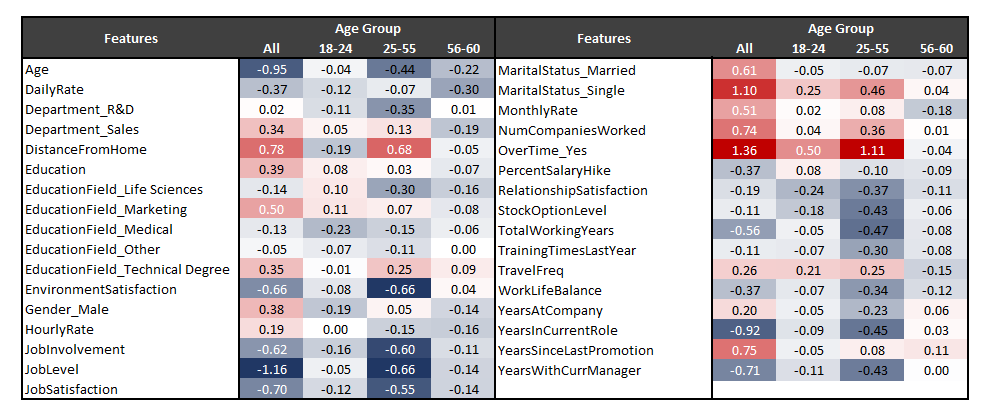

In [18]:
Image('LR Output.png')

# References
Watson Analytics Forum. (2017). _HR Employee Attrition Sample Data Set Origin - Discussions_. [online] Available at: https://community.watsonanalytics.com/discussions/questions/18014/hr-employee-attrition-sample-data-set-origin.html [Accessed 14 Dec. 2017]

Ton, Z. and Huckman, R.S., 2008. Managing the impact of employee turnover on performance: The role of process conformance. _Organization Science_, 19(1), pp.56-68.

Oxford Economics (2017). _The cost of Brain Drain: Understanding the financial impact of staff turnover_. [online] Oxford: Oxford Economics, pp.8 - 27. Available at: https://www.oxfordeconomics.com/publication/open/246524 [Accessed 14 Dec. 2017].#

Ongori, H., 2007. A review of the literature on employee turnover.

Cohen, A. and Golan, R., 2007. Predicting absenteeism and turnover intentions by past absenteeism and work attitudes: An empirical examination of female employees in long term nursing care facilities. _Career Development International_, 12(5), pp.416-432.

Morrell, K.M., Loan-Clarke, J. and Wilkinson, A.J., 2004. Organisational change and employee turnover. _Personnel Review_, 33(2), pp.161-173.

Ekkehart, S., 2006. Labour Turnover, Wage Structure, and Natural Unemployment. _Journal of Institutional and Theoretical Economics_, 134(2), pp.337-364.

Cotton, John & M. Tuttle, Jeffrey. (1986). Employee Turnover: A Meta-Analysis and Review With Implications for Research. _Academy of Management Review_. 11. 55-70. 10.5465/AMR.1986.4282625. 

Armstrong, M. and Taylor, S., 2014. Armstrong's handbook of human resource management practice. Kogan Page Publishers.

Iqbal, A., 2010. Employee turnover: Causes, consequences and retention strategies in the Saudi organizations. _The Business Review_, Cambridge, 16(2), pp.275-281.

Hom, P.W. and Kinicki, A.J., 2001. Toward a greater understanding of how dissatisfaction drives employee turnover. _Academy of Management journal_, 44(5), pp.975-987.

Michaels, C.E. and Spector, P.E., 1982. Causes of employee turnover: A test of the Mobley, Griffeth, Hand, and Meglino model. _Journal of applied psychology_, 67(1), p.53.

Ahituv, A. and Lerman, R.I., 2005. Job Turnover, Wage Rates, and Marital Stability: How Are They Related?.

Palei, S.K. and Das, S.K., 2009. Logistic regression model for prediction of roof fall risks in bord and pillar workings in coal mines: An approach. Safety Science, 47(1), pp.88-96.

Kotsiantis, S.B., Zaharakis, I. and Pintelas, P., 2007. Supervised machine learning: A review of classification techniques.

Ioffe, S. and Szegedy, C., 2015, June. Batch normalization: Accelerating deep network training by reducing internal covariate shift. In International Conference on Machine Learning (pp. 448-456).

Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P., 2002. SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, pp.321-357.